In [191]:
import xarray as xr
import os
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd

In [12]:
cloud = xr.open_dataset("data/cesm_StdModel/cloud_std.nc")
cloud = cloud.CLOUD
cloud

<xarray.DataArray 'CLOUD' (time: 1032, lat: 192, lon: 288)> Size: 228MB
[57065472 values with dtype=float32]
Coordinates:
    lev      float64 8B ...
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 8kB 1920-01-16 1920-02-13 ... 2005-12-16
    month    (time) int64 8kB ...
    year     (time) int64 8kB ...
Attributes:
    mdims:         1
    units:         fraction
    long_name:     Cloud fraction
    cell_methods:  time: mean

This file features multiple visualizations of the data

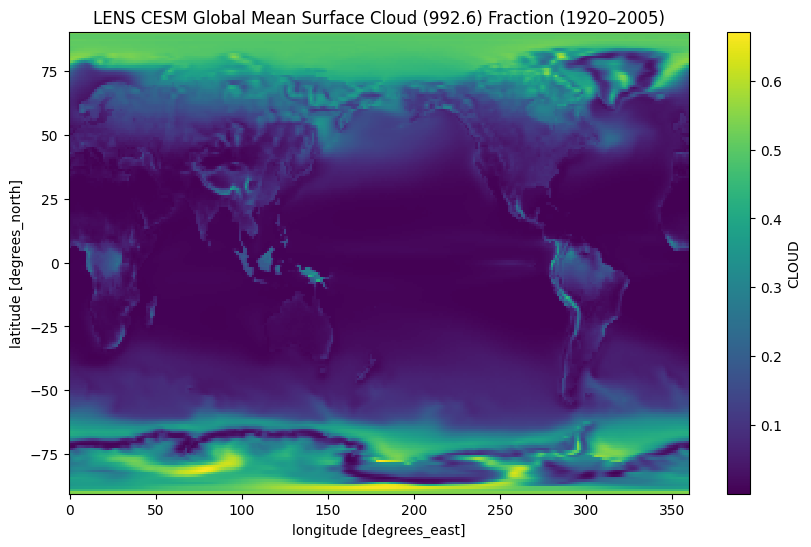

In [29]:
#cloud.mean('time').plot()

fig, ax = plt.subplots(figsize=(10, 6))
cloud.mean('time').plot(ax= ax)
ax.set_title("LENS CESM Global Mean Surface Cloud (992.6) Fraction (1920–2005)")

plt.savefig("dataViz/LENS_Global_Mean_Map")
plt.show()

In [102]:
"""Define Special Ranges"""
#left, right, bottom, top
#lon_min, lon_max, lat_min, lon_max
NEP = [190, 243, 21, 62]
#CA = [170,205, 115, 150]

**Seasonal Means**

In [15]:
def select_season(data, months, season_name):
    # Filter by month
    season_data = data.where(data.month.isin(months), drop=True)
    
    # For DJF, we need to handle the year roll
    if season_name == 'DJF':
        # Drop December of the last year to avoid incomplete season
        season_data = season_data.sel(time=season_data['time'].dt.month != 12) if season_data.time[-1].dt.month == 12 else season_data
        
    return season_data

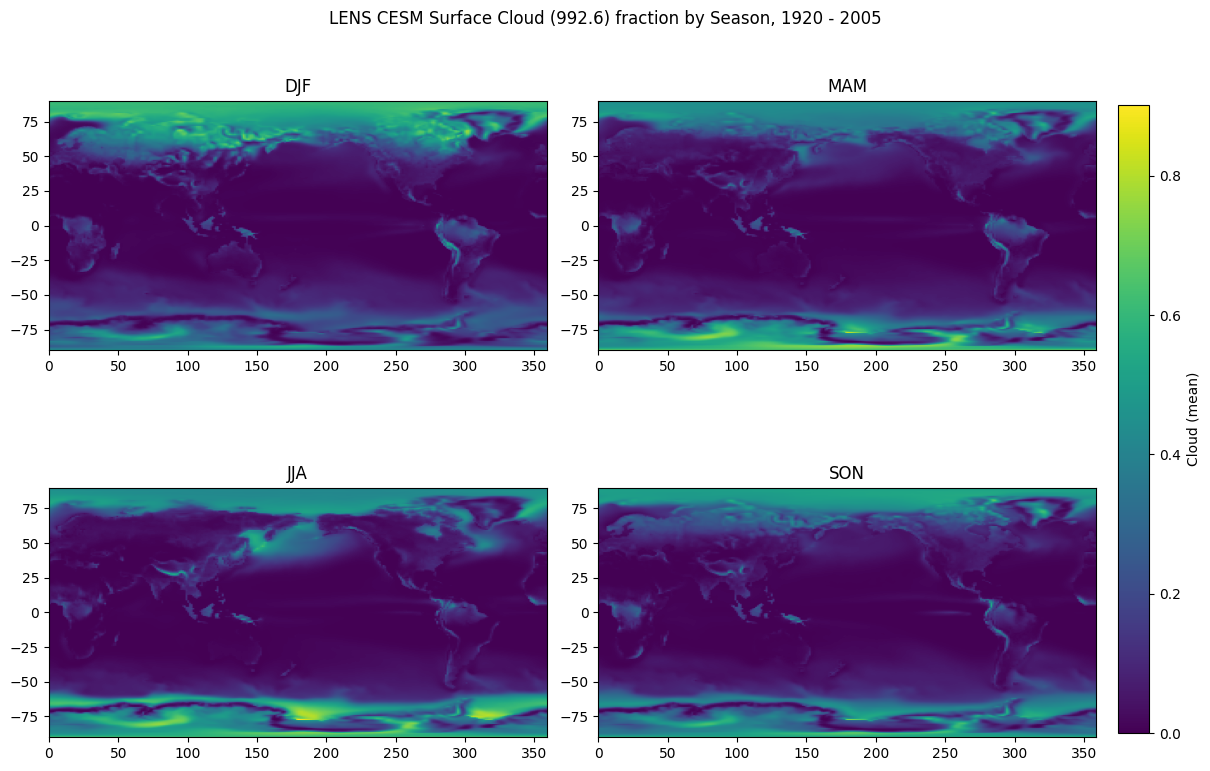

In [80]:
#global seasonal mean

djf = select_season(cloud, [12, 1, 2], "DJF").mean("time")
mam = select_season(cloud, [3, 4, 5], "MAM").mean("time")
jja = select_season(cloud, [6, 7, 8], "JJA").mean("time")
son = select_season(cloud, [9, 10, 11], "SON").mean("time")

djf_data = djf.values
mam_data = mam.values
jja_data = jja.values
son_data = son.values

# Coordinates (for labeling)
lat = djf['lat'].values
lon = djf['lon'].values

fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
fig.suptitle("LENS CESM Surface Cloud (992.6) fraction by Season, 1920 - 2005")

# Set shared color range (optional)
vmin = min(djf_data.min(), mam_data.min(), jja_data.min(), son_data.min())
vmax = max(djf_data.max(), mam_data.max(), jja_data.max(), son_data.max())

# Plot manually
im0 = axs[0, 0].imshow(djf_data, origin='lower', vmin=vmin, vmax=vmax, extent=[lon.min(), lon.max(), lat.min(), lat.max()])
axs[0, 0].set_title("DJF")

im1 = axs[0, 1].imshow(mam_data, origin='lower', vmin=vmin, vmax=vmax, extent=[lon.min(), lon.max(), lat.min(), lat.max()])
axs[0, 1].set_title("MAM")

im2 = axs[1, 0].imshow(jja_data, origin='lower', vmin=vmin, vmax=vmax, extent=[lon.min(), lon.max(), lat.min(), lat.max()])
axs[1, 0].set_title("JJA")

im3 = axs[1, 1].imshow(son_data, origin='lower', vmin=vmin, vmax=vmax, extent=[lon.min(), lon.max(), lat.min(), lat.max()])
axs[1, 1].set_title("SON")

fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.03, pad=0.02, label='Cloud (mean)')

plt.savefig("dataViz/LENS_Global_Seasonal_Map")
plt.show()

[190, 243, 21, 62]


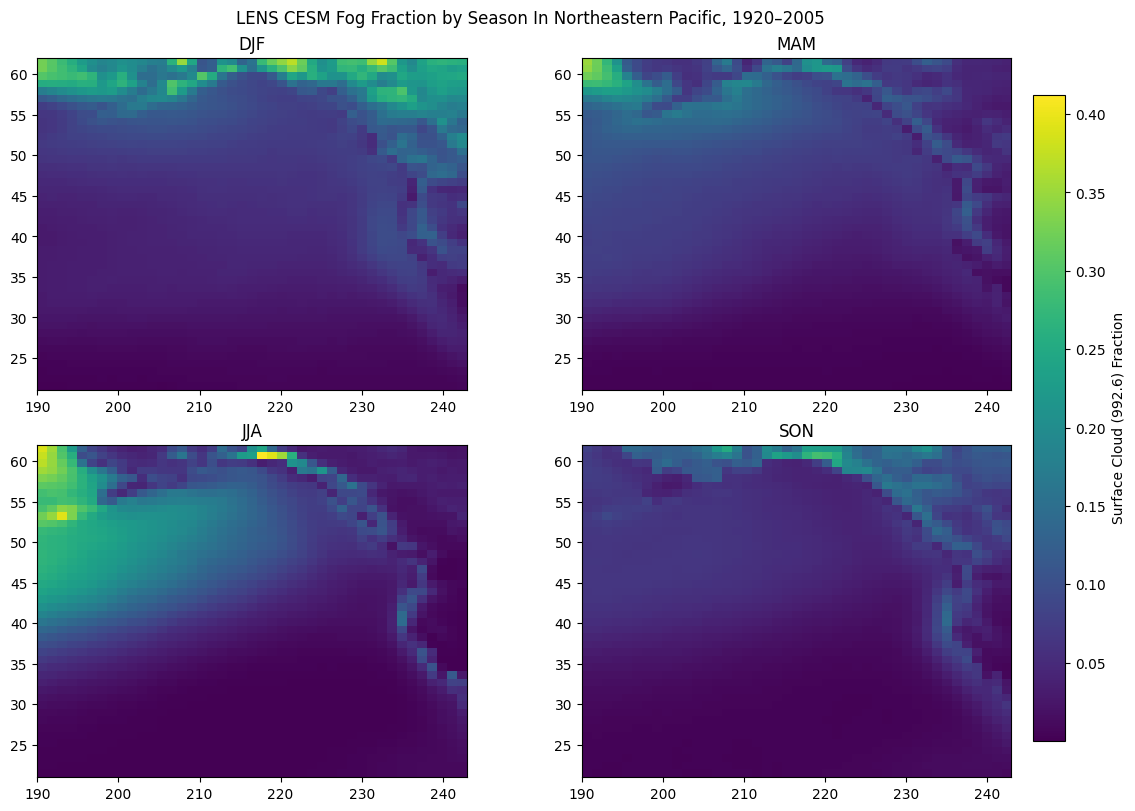

In [107]:
#Northeast Pacific Seasonal Mean

# Prepare figure
fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
fig.suptitle("LENS CESM Fog Fraction by Season In Northeastern Pacific, 1920–2005")

# Define spatial bounds
lat_bounds = slice(NEP[2], NEP[3])
lon_bounds = slice(NEP[0], NEP[1])

# Seasonal arrays and titles
seasonal_data = [djf, mam, jja, son]
titles = ["DJF", "MAM", "JJA", "SON"]

# Subset and compute vmin/vmax from the selected region
subsets = [s.sel(lat=lat_bounds, lon=lon_bounds) for s in seasonal_data]
vmin = min(s.min().item() for s in subsets)
vmax = max(s.max().item() for s in subsets)

#extent = [subsets[1].lon.values.min(), subsets[1].lon.values.max(), subsets[1].lat.values.min(), subsets[1].lat.values.max()]
extent = [NEP[0], NEP[1], NEP[2], NEP[3]]

print(extent)

# Plot all 4 subplots in a loop
for ax, data, title in zip(axs.flat, subsets, titles):
    im = ax.imshow(data.values, origin='lower', vmin=vmin, vmax=vmax, extent=extent)
    ax.set_title(title)

# Shared colorbar
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.03, pad=0.02, label='Surface Cloud (992.6) Fraction')

plt.savefig("dataViz/LENS_NEP_Seasonal_Map")
plt.show()


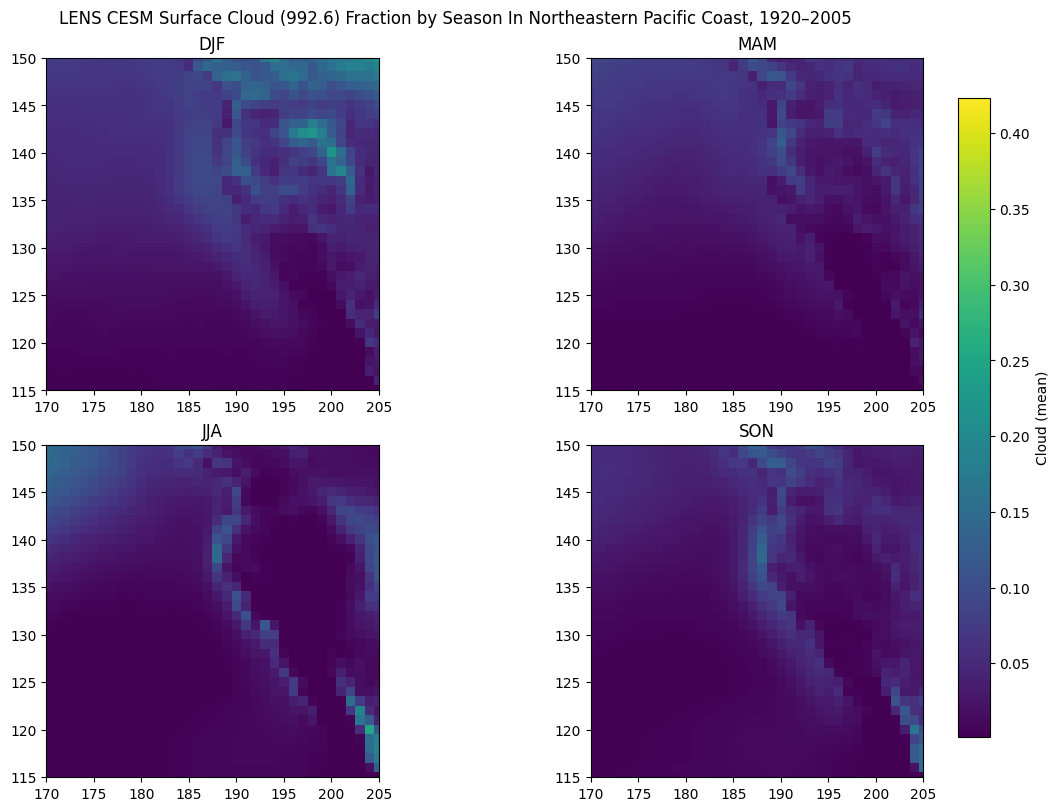

In [25]:
#Northeast Pacific Coast Seasonal Mean #incorrect scale

# Prepare figure
fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
fig.suptitle("LENS CESM Surface Cloud (992.6) Fraction by Season In Northeastern Pacific Coast, 1920–2005")

# Define spatial bounds
lat_bounds = slice(CA[2] - 90, CA[3] - 90)
lon_bounds = slice(CA[0], CA[1])

# Seasonal arrays and titles
seasonal_data = [djf, mam, jja, son]
titles = ["DJF", "MAM", "JJA", "SON"]

# Subset and compute vmin/vmax from the selected region
subsets = [s.sel(lat=lat_bounds, lon=lon_bounds) for s in seasonal_data]
vmin = min(s.min().item() for s in subsets)
vmax = max(s.max().item() for s in subsets)

# Plot all 4 subplots in a loop
for ax, data, title in zip(axs.flat, seasonal_data, titles):
    im = ax.imshow(data.values, origin='lower', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlim(CA[0], CA[1])
    ax.set_ylim(CA[2], CA[3])

# Shared colorbar
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.03, pad=0.02, label='Cloud (mean)')

plt.savefig("dataViz/LENS_NEPCoast_Seasonal_Map")
plt.show()

**Time Series**

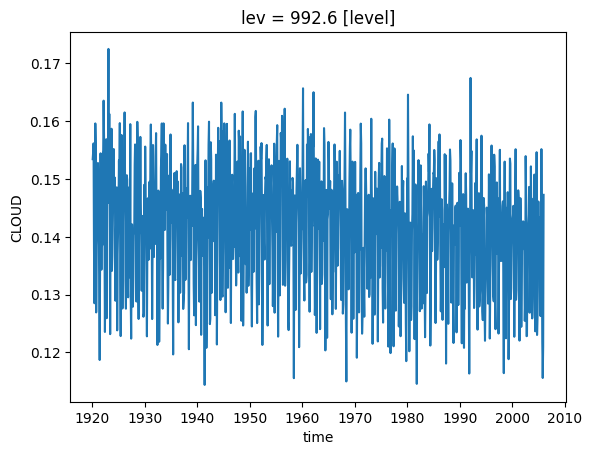

In [26]:
cloud.mean(dim=["lat", "lon"]).plot()

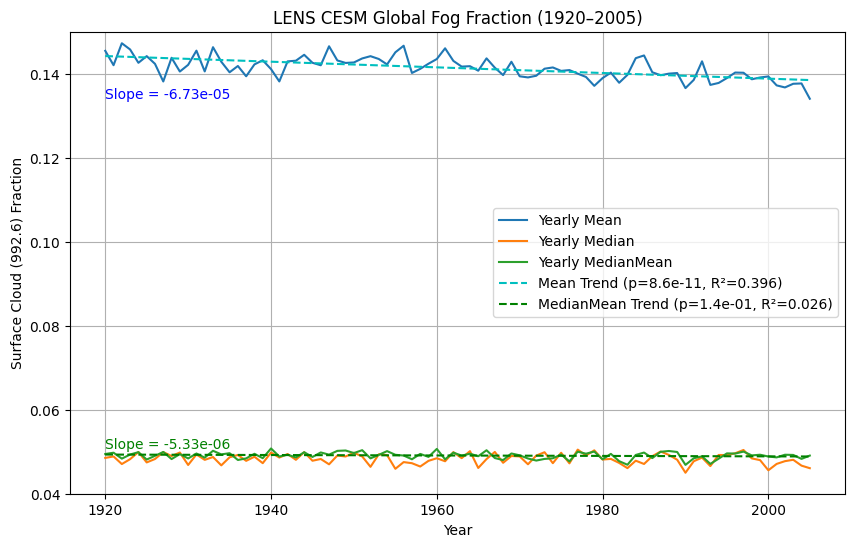

In [189]:
#yearly global mean time series 1920 - 2005
yrly_cloud_mean = cloud.mean(dim=["lat", "lon"]).groupby("year").mean(dim="time")
yrly_cloud_median = cloud.median(dim=["lat", "lon"]).groupby("year").median(dim="time")
yrly_cloud_medianMean = cloud.median(dim=["lat", "lon"]).groupby("year").mean(dim="time")

# Extract year and values
x_mean = yrly_cloud_mean['year'].values
y_mean = yrly_cloud_mean.values

x_medianMean = yrly_cloud_medianMean['year'].values
y_medianMean = yrly_cloud_medianMean.values # array of arrays

# Linear regression
slope_mean, intercept, r_value, p_value_mean, std_err = stats.linregress(x_mean, y_mean)
r_squared_mean = r_value**2
# Compute trend 
trend_line_mean = slope_mean * x_mean + intercept #x is an array so trend_line is array

# Linear regression
slope_medianMean, intercept, r_value, p_value_medianMean, std_err = stats.linregress(x_medianMean, y_medianMean)
r_squared_medianMean = r_value**2
# Compute trend 
trend_line_medianMean = slope_medianMean * x_medianMean + intercept #x is an array so trend_line is array


# Plot
fig, ax = plt.subplots(figsize=(10, 6))

yrly_cloud_mean.plot(ax=ax, label="Yearly Mean")
yrly_cloud_median.plot(ax=ax, label="Yearly Median")
yrly_cloud_medianMean.plot(ax=ax, label="Yearly MedianMean")
ax.plot(x_mean, trend_line_mean, 'c--', label=f"Mean Trend (p={p_value_mean:.1e}, R²={r_squared_mean:.3f})")
ax.plot(x_medianMean, trend_line_medianMean, 'g--', label=f"MedianMean Trend (p={p_value_medianMean:.1e}, R²={r_squared_medianMean:.3f})")

# Annotations
ax.set_title("LENS CESM Global Fog Fraction (1920–2005)")
ax.set_xlabel("Year")
ax.set_ylabel("Surface Cloud (992.6) Fraction")
ax.set_ylim((.04, .15))
ax.legend()
ax.grid(True)

text = f"Slope = {slope_mean:.2e}"
ax.text(1920, y_mean.min(), text, color='b')

text = f"Slope = {slope_medianMean:.2e}"
ax.text(1920, y_medianMean.max(), text, color='g')

plt.savefig("dataViz/LENS_Global_Yrly_TimeSeries")
plt.show()


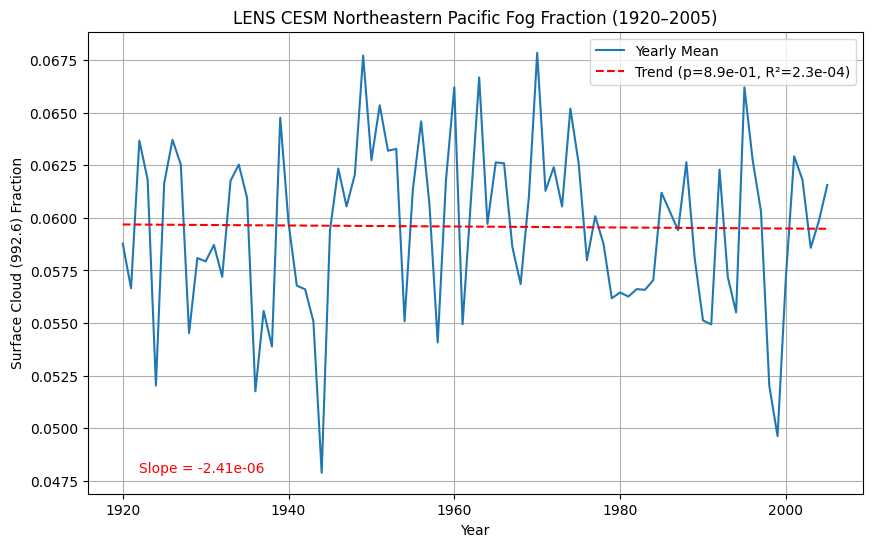

In [159]:
#yearly mean for NEP
lat_bounds = slice(NEP[2], NEP[3])
lon_bounds = slice(NEP[0], NEP[1])
NEP_cloud = cloud.sel(lat=lat_bounds, lon=lon_bounds)
#NEP_cloud.mean("time").plot()

yrly_NEP_cloud = NEP_cloud.mean(dim=["lat", "lon"])
yrly_NEP_cloud = yrly_NEP_cloud.groupby("year").mean(dim="time")

# Trend
x = yrly_NEP_cloud['year'].values
y = yrly_NEP_cloud.values

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_squared = r_value**2
trend_line = slope * x + intercept 

fig, ax = plt.subplots(figsize=(10, 6))

yrly_NEP_cloud.plot(ax=ax, label="Yearly Mean")
ax.plot(x, trend_line, 'r--', label=f"Trend (p={p_value:.1e}, R²={r_squared:.1e})")

ax.set_title("LENS CESM Northeastern Pacific Fog Fraction (1920–2005)")
ax.set_xlabel("Year")
ax.set_ylabel("Surface Cloud (992.6) Fraction")
ax.legend()
ax.grid(True)

text = f"Slope = {slope:.2e}"
ax.text(x[2], min(y), text, color='red')

plt.savefig("dataViz/LENS_NEP_Yrly_TimeSeries")
plt.show()


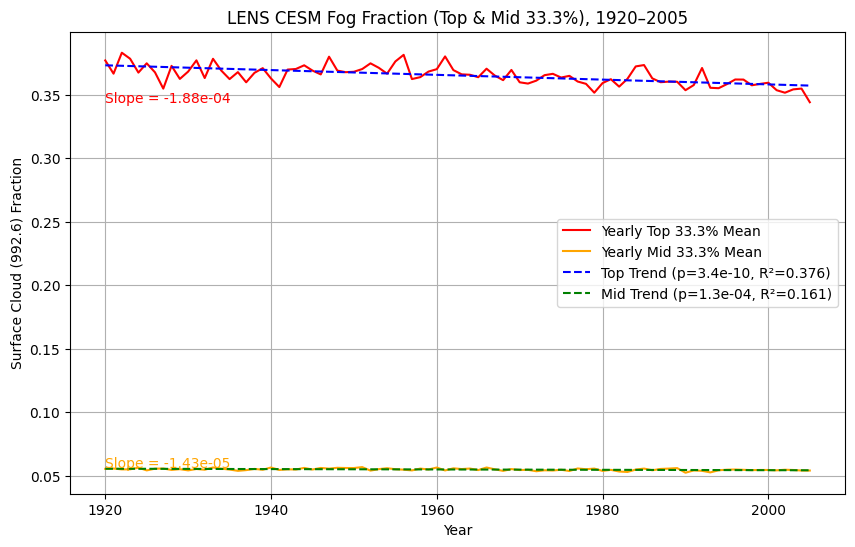

In [270]:
#top and mid thirds globally

# ===== Step 1: Compute monthly mean for top 33.3% and mid 33.3% =====
top_third_means = []
mid_third_means = []
years = []

for t in cloud.time:
    monthValues = cloud.sel(time=t).values.flatten()

    if len(monthValues) == 0:
        continue

    # Compute thresholds
    p33 = np.percentile(monthValues, 33.3)
    p66 = np.percentile(monthValues, 66.6)

    # Group and average
    top_mean = monthValues[monthValues > p66].mean()
    mid_mean = monthValues[(monthValues >= p33) & (monthValues <= p66)].mean()

    top_third_means.append(top_mean)
    mid_third_means.append(mid_mean)
    years.append(pd.to_datetime(str(t.values)).year)

# ===== Step 2: Make dataframe and compute yearly mean =====
df = pd.DataFrame({
    "year": years,
    "top_33": top_third_means,
    "mid_33": mid_third_means
})

yrly_top33 = df.groupby("year")["top_33"].mean()
yrly_mid33 = df.groupby("year")["mid_33"].mean()

# ===== Step 3: Trend lines =====
x_top = yrly_top33.index.values
y_top = yrly_top33.values
slope_top, intercept_top, r_top, p_top, stderr_top = stats.linregress(x_top, y_top)
trend_top = slope_top * x_top + intercept_top
r2_top = r_top**2

x_mid = yrly_mid33.index.values
y_mid = yrly_mid33.values
slope_mid, intercept_mid, r_mid, p_mid, stderr_mid = stats.linregress(x_mid, y_mid)
trend_mid = slope_mid * x_mid + intercept_mid
r2_mid = r_mid**2

# ===== Step 4: Plot =====
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_top, y_top, label="Yearly Top 33.3% Mean", color="red")
ax.plot(x_mid, y_mid, label="Yearly Mid 33.3% Mean", color="orange")

ax.plot(x_top, trend_top, 'b--', label=f"Top Trend (p={p_top:.1e}, R²={r2_top:.3f})")
ax.plot(x_mid, trend_mid, 'g--', label=f"Mid Trend (p={p_mid:.1e}, R²={r2_mid:.3f})")

# ===== Annotations and labels =====
ax.set_title("LENS CESM Fog Fraction (Top & Mid 33.3%), 1920–2005")
ax.set_xlabel("Year")
ax.set_ylabel("Surface Cloud (992.6) Fraction")
ax.grid(True)
ax.legend()

# Trend text
ax.text(1920, y_top.min(), f"Slope = {slope_top:.2e}", color='red')
ax.text(1920, y_mid.max(), f"Slope = {slope_mid:.2e}", color='orange')

plt.savefig("dataViz/LENS_Global_TopMid33_TimeSeries")
plt.show()


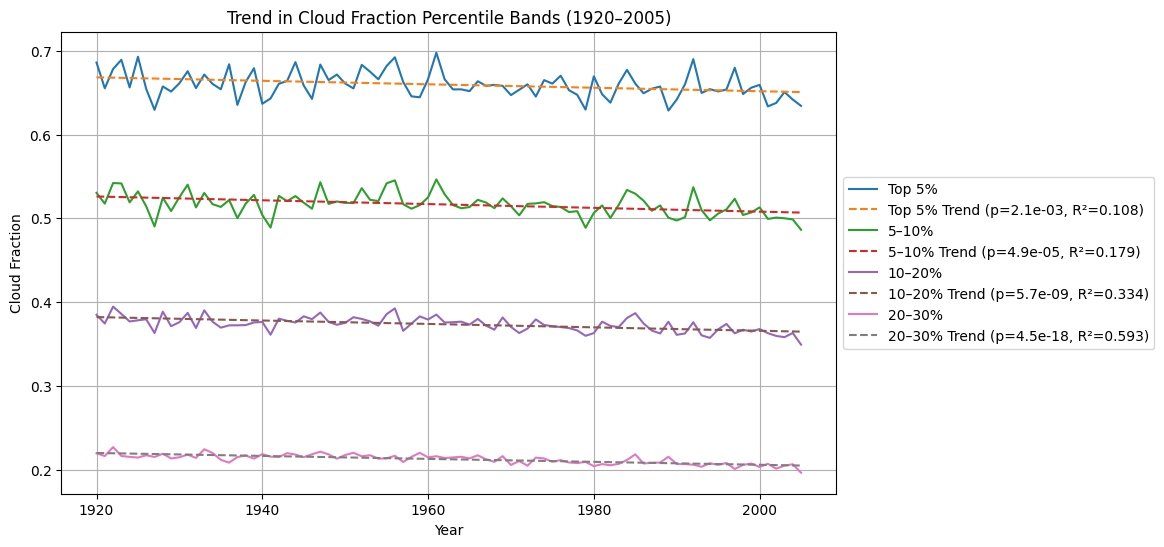

In [ ]:
# Define the percentile cutoffs and labels
percentiles = [95, 90, 80, 70]
labels = ["Top 5%", "5–10%", "10–20%", "20–30%"]

# Initialize dictionary to store results
monthly_data = {label: [] for label in labels}
years = []

# Step 1: Loop through time and compute percentile-band means
for t in cloud.time:
    data = cloud.sel(time=t)
    values = data.values.flatten()
    values = values[~np.isnan(values)]
    if len(values) == 0:
        continue

    p = np.percentile(values, percentiles)

    # Get band means
    monthly_data["Top 5%"].append(np.mean(values[values > p[0]]))
    monthly_data["5–10%"].append(np.mean(values[(values > p[1]) & (values <= p[0])]))
    monthly_data["10–20%"].append(np.mean(values[(values > p[2]) & (values <= p[1])]))
    monthly_data["20–30%"].append(np.mean(values[(values > p[3]) & (values <= p[2])]))
    years.append(pd.to_datetime(str(t.values)).year)

# Step 2: Build a DataFrame and group by year
df = pd.DataFrame(monthly_data)
df["year"] = years
yearly_means = df.groupby("year").mean()

# Step 3: Plot all bands and their trend lines
fig, ax = plt.subplots(figsize=(10, 6))

for label in labels:
    y = yearly_means[label].values
    x = yearly_means.index.values

    # Plot time series
    ax.plot(x, y, label=label)

    # Linear regression
    slope, intercept, r_value, p_value, _ = stats.linregress(x, y)
    trend = slope * x + intercept
    ax.plot(x, trend, linestyle="--", label=f"{label} Trend (p={p_value:.1e}, R²={r_value**2:.3f})")

# Step 4: Formatting
ax.set_title("Trend in Cloud Fraction Percentile Bands (1920–2005)")
ax.set_xlabel("Year")
ax.set_ylabel("Cloud Fraction")
ax.grid(True)
ax.legend()

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("dataViz/LENS_Global_Yrly_PercentileBands_Trend")
plt.show()

**Histogram of Fraction** </br>
*aka fraction on the x axis and occurance on the y axis*

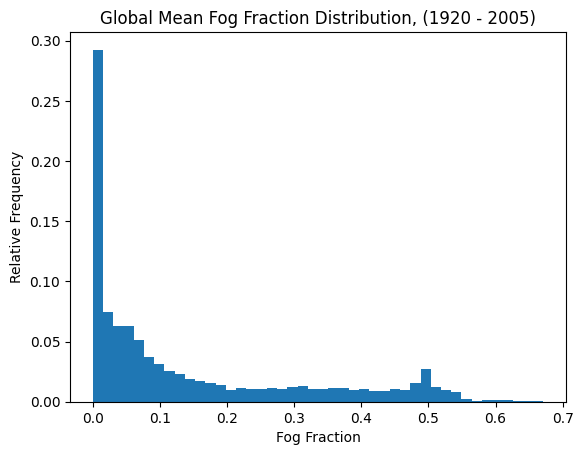

In [152]:
#global, mean per cell across all yrs

globalMean = cloud.mean("time")
x = globalMean.values
counts, bins = np.histogram(x, "scott")
plt.hist(bins[:-1], bins, weights=counts/counts.sum())

plt.title("Global Mean Fog Fraction Distribution, (1920 - 2005)")
plt.xlabel("Fog Fraction")
plt.ylabel("Relative Frequency")

plt.savefig("dataViz/LENS_Global_FogFraction_Distribution")
plt.show()


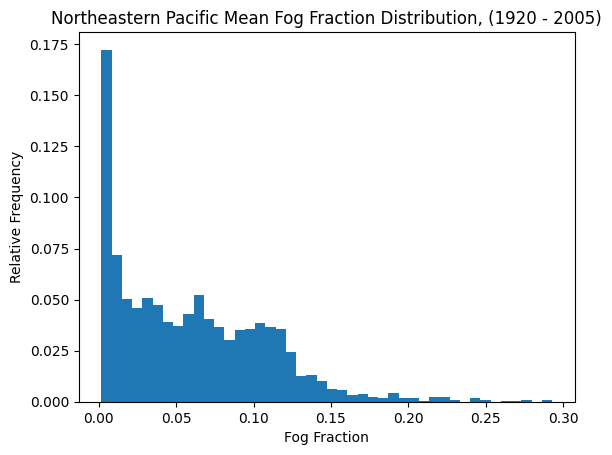

In [169]:
#NEP

NEPMean = NEP_cloud.mean("time")
x = NEPMean.values
counts, bins = np.histogram(x, "sqrt")
plt.hist(bins[:-1], bins, weights=counts/counts.sum())

plt.title("Northeastern Pacific Mean Fog Fraction Distribution, (1920 - 2005)")
plt.xlabel("Fog Fraction")
plt.ylabel("Relative Frequency")

plt.savefig("dataViz/LENS_NEP_FogFraction_Distribution")
plt.show()